In [10]:
from models import vae_v2_EUCL, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

In [11]:
image_size = 28
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)

num_data = list(range(0, 2000))
#odds = list(range(1, len(trainset), 2))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
#trainset_2 = torch.utils.data.Subset(trainset, odds)

#subset_indices = torch.randperm(len(trainset))[:1000]

# trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=256,
#                                         sampler=SubsetRandomSampler(subset_indices), 
#                                          num_workers=6, pin_memory=True)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=256, 
                                         num_workers=6, pin_memory=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()




In [12]:
model = vae_EUCL.VariationalAutoencoder(latent_dims=4)
#model = vae_v2_EUCL.VariationalAutoencoder(3, 64, 4)

In [13]:
learning_rate = 8e-3

In [14]:
#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [16]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [17]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().permute(1, 2, 0).numpy())  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 406467.468750
	 partial train loss (single batch): 425929.406250
	 partial train loss (single batch): 404462.718750
	 partial train loss (single batch): 387532.593750
	 partial train loss (single batch): 380835.406250
	 partial train loss (single batch): 346378.750000
	 partial train loss (single batch): 346115.281250
	 partial train loss (single batch): 280175.187500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/20 	 train loss 1488.948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


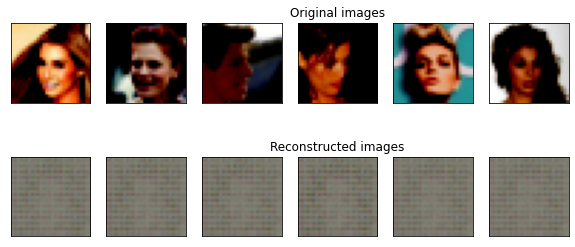

KeyboardInterrupt: 

In [18]:
num_epochs = 20

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [ ]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)



from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

#Davies-Bouldin Index
db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
print(db_index)

#Calinski-Harabasz Index
ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# print(s_coeff)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

NameError: name 'testset' is not defined

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# print(s_coeff)
fig.show()